## Imports

In [20]:
import load_data
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os

In [58]:
SAVE_HISTORY = True

## Load Data

In [4]:
load_data.read_data()
load_data.split_data()
load_data.create_train_and_test_data()
load_data.get_vocabulary_length_and_clean_labels()
load_data.clean_test_labels()

x_train_img_paths, y_train_labels = load_data.train_img_paths, load_data.train_labels_cleaned
x_test_img_paths, y_test_labels = load_data.test_img_paths, load_data.test_labels_cleaned

Dataset contains: 11344 lines
Total train samples: 10209
Total test samples: 1135
Total train samples: 10209
Total test samples: 1135
Maximum length:  93
Vocab size:  79
Labels Cleaned:
['and|Haris|there|were|many|events|.|Chief|of|these|was', 'adjust|the|financing|-|which|Mr.|Powell', 'right|to|blame|the|politicians|unless|they|see', 'from|the|dissection|of|living|animals|,|showing|how|these|move-', 'Nationalists|and|20|United|party|candi-', 'In|unions|where|the|central|issues', 'walked|together|across|green|fields|,|and', 'for|easy|cleaning|and|then|fixed|underneath', 'Diocese|.', 'against|African|fanatics|and|woolly|minded']


## Create Dataset

In [5]:
# Has to be here because load data functions need to be called before
import tokenizer
import preprocess

# takes eternity
#x_train, y_train = tokenizer.prepare_data(x_train_img_paths, y_train_labels) 
#x_test, y_test = tokenizer.prepare_data(x_test_img_paths, y_test_labels)
train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels)
test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels)

## Show Examples

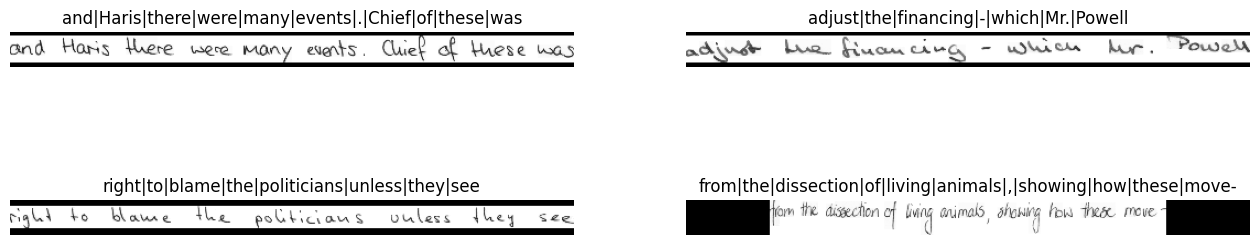

In [6]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(2, 2, figsize=(16, 4))

    for i in range(4):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(label)
        ax[i // 2, i % 2].axis("off")


plt.show()

## CTC Layer

In [7]:
import keras
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

## Keras Model

In [8]:
image_width = preprocess.image_width
image_height = preprocess.image_height
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(tokenizer.char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

In [9]:
# Get the model.
model = build_model()
model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 512, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 512, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 256, 16, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 256, 16, 64)  18496       ['pool1[0][0

In [14]:
epochs = 100  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
)

Epoch 1/100
160/160 [==============================] - 21s 103ms/step - loss: 143.7903 - val_loss: 135.6702
Epoch 2/100
160/160 [==============================] - 15s 94ms/step - loss: 134.3399 - val_loss: 135.3914
Epoch 3/100
160/160 [==============================] - 15s 93ms/step - loss: 131.9227 - val_loss: 124.6142
Epoch 4/100
160/160 [==============================] - 15s 96ms/step - loss: 117.3048 - val_loss: 108.8883
Epoch 5/100
160/160 [==============================] - 15s 95ms/step - loss: 102.5515 - val_loss: 92.8673
Epoch 6/100
160/160 [==============================] - 15s 95ms/step - loss: 90.4042 - val_loss: 81.3105
Epoch 7/100
160/160 [==============================] - 15s 96ms/step - loss: 81.8010 - val_loss: 72.9361
Epoch 8/100
160/160 [==============================] - 15s 97ms/step - loss: 74.8606 - val_loss: 66.5561
Epoch 9/100
160/160 [==============================] - 15s 96ms/step - loss: 69.3157 - val_loss: 61.3343
Epoch 10/100
160/160 [=======================

## Test the Model


In [73]:
def plot_history_simple(history):
    """
    Plottet die Historie des Trainings eines Models

    :param history: Das trainierte Modell
    :return: void
    """
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.show()

In [74]:
def plot_history(history, name, dir_path):
    """
    Plottet die Historie des Trainings eines Models und speichert die in einem Verzeichnis ab 

    :param history: Das trainierte Modell
    :param name: Name, wie das Modell gespeicht werden soll
    :param name: Verzeichniss, wo der Plot gespeichert weren soll
    :return: void
    """
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.title('Name: '+name)
    path = os.path.join(dir_path, name + '_history.png')
    plt.savefig(path)
    plt.show()

In [75]:
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [76]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :load_data.max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [77]:
def plot_evaluation(name, dir_path):
        # Let's check results on some test samples.
    for batch in test_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 4))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
            
    path = os.path.join(dir_path, name + '_result.png')
    plt.savefig(path)

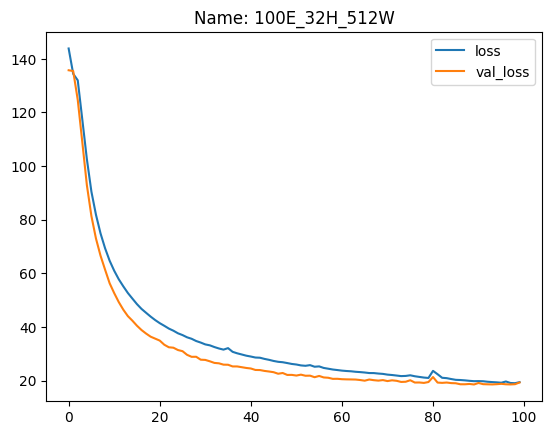

2/2 [==============================] - 0s 21ms/step


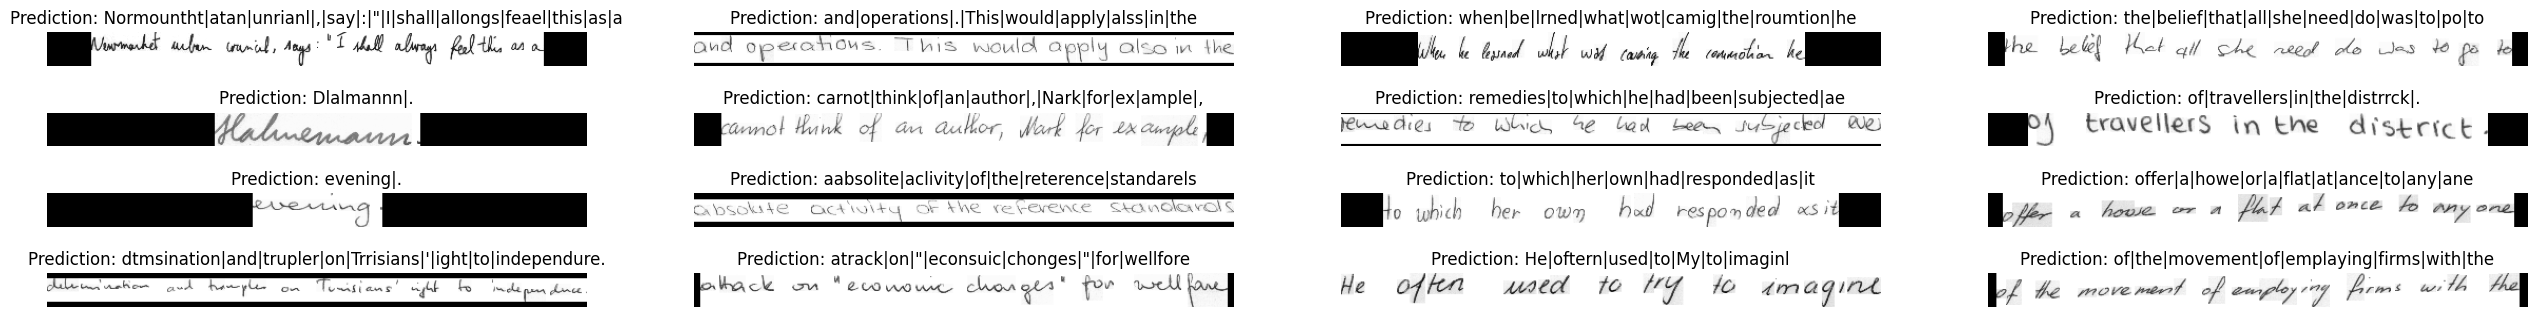

In [78]:
NAME = "{epoch}E_{height}H_{width}W".format(epoch=epochs, height=image_height, width=image_width)

if SAVE_HISTORY:
    TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath('test_results')
    if not os.path.exists(TEST_RESULT_DIR_NAME):
        create_dir(TEST_RESULT_DIR_NAME)
    plot_history(history, NAME, TEST_RESULT_DIR_NAME)
    plot_evaluation(NAME, TEST_RESULT_DIR_NAME)
else:
     plot_history_simple(history)


# Save the Model

In [79]:
model.save("model.keras")
model.save_weights("weights.keras", overwrite=True, save_format=None, options=None)
json_string = model.to_json()

with open('model','w') as f:
    f.write(json_string)